## Rank Dynamics Analysis

This notebook analyzes how book rankings change week over week on the New York Times Hardcover Fiction bestseller list. The goal is to understand rank stability, volatility, and patterns of movement over time.


In [2]:
import pandas as pd

df = pd.read_csv("../data/processed/history/nyt_history_weekly.csv")

# df["published_date"] = pd.to_datetime(df["published_date"])
# df["bestsellers_date"] = pd.to_datetime(df["bestsellers_date"])

# Sort correctly for time-series analysis
df = df.sort_values(
    ["title", "published_date"]
).reset_index(drop=True)

df.head()


,published_date,bestsellers_date,list_name,title,author,primary_isbn13,publisher,rank,rank_last_week,weeks_on_list,amazon_product_url,book_image,description
0,2025-07-20,2025-07-05,Hardcover Fiction,A FORBIDDEN ALCHEMY,Stacey McEwan,9781668076187,Saga,5,0,1,https://www.amazon.com/dp/1668076187?tag=thene...,https://static01.nyt.com/bestsellers/images/97...,"As war looms, Nina Harrow must make a fate-alt..."
1,2025-07-13,2025-06-28,Hardcover Fiction,A MOTHER'S LOVE,Danielle Steel,9780593498736,Delacorte,3,0,1,https://www.amazon.com/dp/0593498739?tag=thene...,https://static01.nyt.com/bestsellers/images/97...,After her handbag is stolen during a trip to P...
2,2025-07-20,2025-07-05,Hardcover Fiction,A MOTHER'S LOVE,Danielle Steel,9780593498736,Delacorte,15,3,2,https://www.amazon.com/dp/0593498739?tag=thene...,https://static01.nyt.com/bestsellers/images/97...,After her handbag is stolen during a trip to P...
3,2025-10-12,2025-09-27,Hardcover Fiction,ALCHEMISED,SenLinYu,9780593972700,Del Rey,1,0,1,https://www.amazon.com/dp/0593972708?tag=thene...,https://static01.nyt.com/bestsellers/images/97...,"After the war, an imprisoned alchemist is sent..."
4,2025-10-19,2025-10-04,Hardcover Fiction,ALCHEMISED,SenLinYu,9780593972700,Del Rey,3,1,2,https://www.amazon.com/dp/0593972708?tag=thene...,https://static01.nyt.com/bestsellers/images/97...,"After the war, an imprisoned alchemist is sent..."


### Rank Change Definition

Rank change is defined as:
current week's rank − previous week's rank

Negative values indicate improvement in rank.

Positive values indicate decline.


In [5]:
df["rank_change"] = df.groupby("title")["rank"].diff()
df[["title", "published_date", "rank", "rank_last_week", "rank_change"]].head(10)

,title,published_date,rank,rank_last_week,rank_change
0,A FORBIDDEN ALCHEMY,2025-07-20,5,0,NaN
1,A MOTHER'S LOVE,2025-07-13,3,0,NaN
2,A MOTHER'S LOVE,2025-07-20,15,3,12.0
3,ALCHEMISED,2025-10-12,1,0,NaN
4,ALCHEMISED,2025-10-19,3,1,2.0
5,ALCHEMISED,2025-10-26,5,3,2.0
6,ALCHEMISED,2025-11-02,5,5,0.0
7,ALCHEMISED,2025-11-09,5,5,0.0
8,ALCHEMISED,2025-11-16,5,5,0.0
9,ALCHEMISED,2025-11-23,3,5,-2.0


NaN rank changes correspond to debut weeks where no prior rank exists.

### Overall Rank Volatility

In [6]:
df["rank_change"].describe()

count    268.000000
mean       1.477612
std        3.961834
min      -10.000000
25%       -1.000000
50%        1.000000
75%        4.000000
max       13.000000
Name: rank_change, dtype: float64

**Interpretation**

Most weekly rank changes are small, with a median change of +1, indicating that books typically shift only slightly from week to week. Negative values (rank improvements) occur but are less frequent and generally modest in size, while positive values (rank declines) are more common and slightly larger on average. The presence of a few extreme changes (as large as ±10–13) suggests occasional sharp drops or surges, likely when titles first enter the list or are about to exit, but overall the ranking system appears relatively stable week to week.

### Which Books Are Most Stable?

In [7]:
stability = (
    df.dropna(subset=["rank_change"])
      .groupby("title")["rank_change"]
      .apply(lambda x: x.abs().mean()) # abs value because direction doesn't matter
      .sort_values()
      .head(10)
)

stability

title
THE SECRET OF SECRETS       1.200000
BRIMSTONE                   1.200000
THE WIDOW                   1.444444
ATMOSPHERE                  1.769231
THE KNIGHT AND THE MOTH     2.000000
MY FRIENDS                  2.000000
ALCHEMISED                  2.076923
DUNGEON CRAWLER CARL        2.125000
GREAT BIG BEAUTIFUL LIFE    2.285714
ONYX STORM                  2.352941
Name: rank_change, dtype: float64

These titles show the least average week-to-week rank movement,indicating strong and consistent popularity.


#### Rank Change Distribution

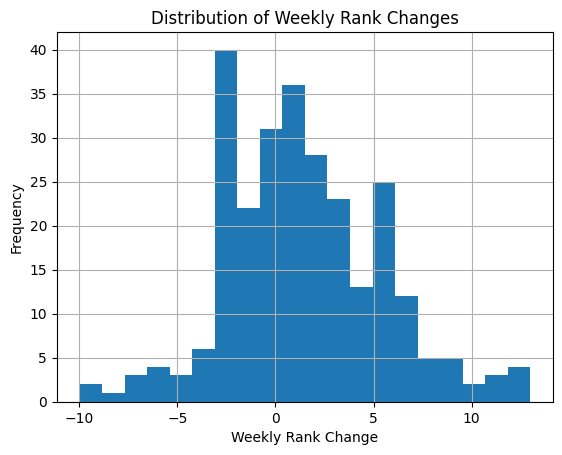

In [8]:
import matplotlib.pyplot as plt

df["rank_change"].dropna().hist(bins=20)
plt.xlabel("Weekly Rank Change")
plt.ylabel("Frequency")
plt.title("Distribution of Weekly Rank Changes")
plt.show()

The distribution is centered close to zero, reinforcing that most books experience only small week-to-week rank movements. The highest concentration lies between roughly −2 and +4, showing mild improvements or declines are the norm. The left tail (negative values) indicates some books make noticeable upward jumps in rank, while the longer right tail shows that sharp drops in rank occur slightly more often. Extreme changes on either side are rare, suggesting that dramatic rank volatility is the exception rather than the rule.

### Example Rank Trajectory

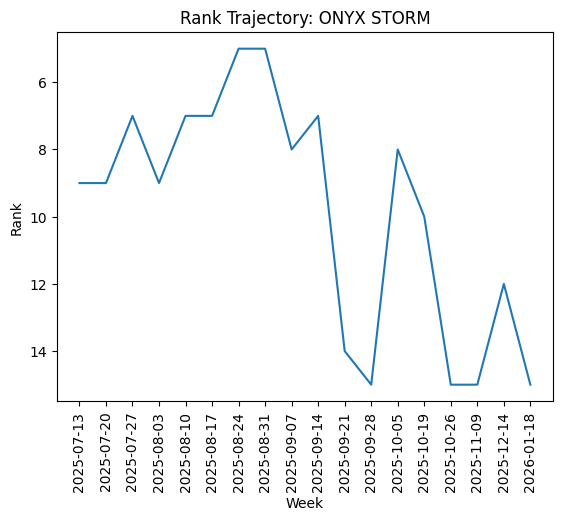

In [11]:
example_title = df["title"].value_counts().index[0]

example = df[df["title"] == example_title]

plt.plot(example["published_date"], example["rank"])
plt.gca().invert_yaxis()
plt.title(f"Rank Trajectory: {example_title}")
plt.xlabel("Week")
plt.xticks(rotation=90)
plt.ylabel("Rank")
plt.show()


**Interpretation**

The rank trajectory for ONYX STORM shows an initial period of relative stability within the top 10, indicating strong early performance and sustained reader interest. This is followed by a sharp decline around late September, where the book drops significantly in rank, suggesting increased competition from new releases or waning momentum. After this drop, the ranks fluctuate at lower positions, with brief recoveries that are not sustained. Overall, the pattern reflects a typical bestseller lifecycle: an early strong presence, a peak, and then gradual decline with intermittent volatility rather than a smooth exit from the list.

**Conclusions — Rank Dynamics Analysis**

- Weekly rank movements are relatively small on average, with a mean rank change close to +1, indicating that most books experience gradual shifts rather than dramatic jumps week over week.
- The distribution of rank changes is centered near zero, showing that rank stability is common once a book enters the bestseller list.
- Large positive or negative rank swings are rare, suggesting that sharp rises or drops typically occur only during special events such as new releases, media attention, or strong competition weeks.
- Books often show volatile behavior after their peak, where brief recoveries are followed by continued declines, reflecting diminishing momentum over time.
- Individual rank trajectories (e.g., ONYX STORM) highlight a lifecycle pattern:

        a) Early stability or improvement
        b) A peak period within the top ranks
        c) A sharp decline

- Lower-rank fluctuations before exit from the list
- Rank dynamics reinforce that bestseller performance is temporal, and sustained top rankings are difficult to maintain without continued external demand or visibility.
- These findings set the foundation for deeper analysis of author consistency, publisher strength, and recommendation logic in subsequent notebooks.

---